# LIFE Star Catalog
## Introduction
One of the main use cases of the LIFE Target Database is to enable the creation of the LIFE Star Catalog (LIFE-StarCat). It is the stellar sample of potential targets that is used by LIFEsim to provide mission yield estimates. In this tutorial we guide you through how the 4th version of this catalog was created. Following our example you can learn how you could create your own catalog for your science project.

Make sure to have this file saved in the correct directory (data_generation/life_td_data_generation) before running it. The file in data_generation/docs/source/tutorials is only intended for proper display on the webpage.

## Getting started
We start by importing the required Python modules for this tutorial. Be aware that you will need to have them installed in your environment for this to work.

In [2]:
import astropy as ap  # Used for votables
import numpy as np  # Used for arrays
import pyvo as vo  # Used for catalog query

Next we import the life_td_data_generation specific functions from the modules.

In [3]:
# Self created modules
from provider.utils import query
from utils.io import save

In case you don't want to download the life_td_data_generation package you can also just use the two functions below.

In [8]:
additional_data_path = "../../additional_data/"


def save(cats, names, location=additional_data_path):
    """
    This functions saves the tables given as list in the cats parameter.

    :param cats: Python list of astropy table to be saved.
    :type cats: list(astropy.table.table.Table)
    :param names: Contains names for saving location
        of tables in cats.
    :type names: list(str)
    :param str location: Defaults to ../../data/additional_data/
    """
    # go through all the elements in both lists
    for cat, path in zip(cats, names):
        # for each column header
        for i in cat.colnames:
            if cat[i].dtype == object:  # object =adaptable length string
                # transform the type into string
                cat[i] = cat[i].astype(str)
        # save the table
        ap.io.votable.writeto(
            ap.io.votable.from_table(cat), f"{location}{path}.xml"
        )
    return


def query(link, query, catalogs=[], no_description=True):
    """
    Performs a query via TAP on the service given in the link parameter.

    If a list of tables is given in the catalogs parameter,
    those are uploaded to the service beforehand.

    :param str link: Service access URL.
    :param str query: Query to be asked of the external database service
         in ADQL.
    :param catalogs: List of astropy tables to be uploaded to the
        service.
    :type catalogs: list(astropy.table.table.Table)
    :param bool no_description: Defaults to True, wether description gets removed
    :returns: Result of the query.
    :rtype: astropy.table.table.Table
    """
    # defining the vo service using the given link
    service = vo.dal.TAPService(link)
    # without upload tables
    if catalogs == []:
        result = service.run_async(query.format(**locals()), maxrec=1600000)
    # with upload tables
    else:
        tables = {}
        for i in range(len(catalogs)):
            tables.update({f"t{i + 1}": catalogs[i]})
        result = service.run_async(
            query, uploads=tables, timeout=None, maxrec=1600000
        )
    cat = result.to_table()

    # removing descriptions because merging of data leaves wrong description
    for col in cat.colnames:
        if no_description:
            cat[col].description = ""

    return cat

## Querying the Database
We will now query the LIFE Target Database (life_td) for the data needed to create the catalog. We specify the distance cut as 30 parsec according to the latest LIFE catalog version (4).

In [4]:
distance_cut = 30.0

Now we define the concrete query. It is one of the provided examples at http://dc.zah.uni-heidelberg.de/life/q/ex/examples and returns parameters for all objects of type star with distances smaller than 30 pc. We also give the link for the service.

In [5]:
adql_query = """
    SELECT o.main_id, sb.coo_ra, sb.coo_dec, sb.plx_value, sb.dist_st_value,
        sb.sptype_string, sb.coo_gal_l, sb.coo_gal_b, sb.teff_st_value,
        sb.mass_st_value, sb.radius_st_value, sb.binary_flag, sb.mag_i_value,
        sb.mag_j_value,  sb.class_lum, sb.class_temp,
        o_parent.main_id AS parent_main_id, sb_parent.sep_ang_value
    FROM life_td.star_basic AS sb
    JOIN life_td.object AS o ON sb.object_idref=o.object_id
    LEFT JOIN life_td.h_link AS h ON o.object_id=h.child_object_idref
    LEFT JOIN life_td.object AS o_parent ON
        h.parent_object_idref=o_parent.object_id
    LEFT JOIN life_td.star_basic AS sb_parent ON
        o_parent.object_id=sb_parent.object_idref
    WHERE o.type = 'st' AND sb.dist_st_value < """ + str(distance_cut)
service = "http://dc.zah.uni-heidelberg.de/tap"

Next we perform the actual query.

In [6]:
catalog = query(service, adql_query)

Let's have a short look at what we got:

In [9]:
print(catalog)

    main_id           coo_ra       ... parent_main_id sep_ang_value
                       deg         ...                    arcsec   
--------------- ------------------ ... -------------- -------------
    *  61 Cyg B  316.7302660185276 ...      *  61 Cyg         184.4
    *  61 Cyg A  316.7247482895925 ...      *  61 Cyg         184.4
    L 1578-44 B  324.1601460120721 ...      L 1578-44           1.0
    L 1578-44 A 324.16073469423293 ...      L 1578-44           1.0
UPM J2325+4717B  351.4090302929913 ... UPM J2325+4717            --
UPM J2325+4717A  351.4091812460812 ... UPM J2325+4717            --
     Ross  200B  325.0050669305063 ...      Ross  200           1.2
     Ross  200A  325.0044367358217 ...      Ross  200           1.2
     HD 239960B  336.9991483422729 ...      HD 239960         141.2
            ...                ... ...            ...           ...
      LP  908-5 180.42532869409166 ...                           --
SIPS J2308-2721 347.04743961483575 ...          

We can see that we obtained a table of about 10'000 stars.

## Processing the result
### Removing non main-sequence stars
For the LIFE mission we are only interested in main sequence stars so in the next step we remove all other stars. We first remove those without main sequence temperature classes (e.g. white dwarfs).

In [7]:
ms_tempclass = np.array(["O", "B", "A", "F", "G", "K", "M"])
cat_ms_tempclass = catalog[
    np.where(np.isin(catalog["class_temp"], ms_tempclass))
]

Next we remove objects that are not main sequence in luminosity class.
Note that the class_lum parameter from the LIFE Target Database assumes V if no luminosity class is given in the sptype_string parameter. This is justified as the main sequence is the longest lasting evolutionary period of a star leaving the great majority of stars in this stage. This assumption was neccessary as the estimated stellar effective temperature, mass and radius values use a relation requiring luminosity class V.

In [8]:
ms_lumclass = np.array(["V"])
cat_ms_lumclass = cat_ms_tempclass[
    np.where(np.isin(cat_ms_tempclass["class_lum"], ms_lumclass))
]
print(cat_ms_lumclass)

    main_id           coo_ra       ... parent_main_id sep_ang_value
                       deg         ...                    arcsec   
--------------- ------------------ ... -------------- -------------
    *  61 Cyg B  316.7302660185276 ...      *  61 Cyg         184.4
    *  61 Cyg A  316.7247482895925 ...      *  61 Cyg         184.4
    L 1578-44 A 324.16073469423293 ...      L 1578-44           1.0
     HD 239960B  336.9991483422729 ...      HD 239960         141.2
     HD 239960A  336.9981564512275 ...      HD 239960         141.2
      HD 179958 288.02093934795624 ...    BD+49  2959          27.2
      HD 179957 288.01949584708956 ...    BD+49  2959          27.2
      Wolf 1084  310.8302599214592 ...      Wolf 1084           0.1
    *  16 Cyg B    295.46655282394 ...      *  16 Cyg          18.2
            ...                ... ...            ...           ...
      L  349-68  298.5005688176708 ...                           --
        MCC 467     85.49527926983 ...          

### Removing higher order multiples
For the LIFE catalog we want single stars and wide binaries that can be approximated as single stars. For that we now split the sample into single and multiple stars:

In [10]:
singles = cat_ms_lumclass[np.where(cat_ms_lumclass["binary_flag"] == "False")]
multiples = cat_ms_lumclass[np.where(cat_ms_lumclass["binary_flag"] == "True")]
print(len(singles), len(multiples))

3001 2012


Next we remove higher order multiples. That means we remove systems like shown in the nextled multiples part of the following figure:
![title](multiplicity.png)

To do that we first remove those objects, where the parent object is a child object as well. In the example above that would be "system AB". For that we need to get the hierarchy table from life_td.

In [11]:
adql_query2 = """
    SELECT o.main_id as child_main_id,o.object_id
    FROM life_td.object AS o
    JOIN life_td.h_link AS h on o.object_id=h.child_object_idref
    """
h_link = query(service, adql_query2)

In [12]:
higher_order_multiples = np.isin(
    multiples["parent_main_id"], h_link["child_main_id"]
)
multiples.remove_rows(higher_order_multiples)

Now we also remove objects that have multiple parent objects, e.g., *  9 Aur has as parent WDS J05067+5136AB, WDS J05067+5136AC and WDS J05067+5136AE given.

In [13]:
multi_parent = []
grouped = multiples.group_by("main_id")
ind = grouped.groups.indices
for i in range(len(ind) - 1):
    if ind[i + 1] - ind[i] != 1:
        multi_parent.append(grouped["main_id"][ind[i]])

single_parent_multiples = grouped[
    np.where(np.invert(np.isin(grouped["main_id"], multi_parent)))
]
print(len(single_parent_multiples))

968


Since we want to get wide binaries the next step is to have a look at the given separation values. We remove those binaries where no separation value is given.

In [14]:
sep_multiples = single_parent_multiples[
    np.where(single_parent_multiples["sep_ang_value"].mask == False)
].copy()

Now we transform the separation values from angular into physical. This is neccessary as we want to look at in a later step at the planetery orbit stability around the habitable zone.

In [15]:
sep_multiples["sep_phys_value"] = sep_multiples[
    "sep_ang_value"
]  # just initiating new column with same properties
sep_multiples["sep_phys_value"].unit = ap.units.AU
for i in range(len(sep_multiples)):
    sep_multiples["sep_phys_value"][i] = np.round(
        sep_multiples["sep_ang_value"][i] * sep_multiples["dist_st_value"][i], 1
    )

Now we only keep those binaries where both components fulfill all our requirements. Meaning the posses the parameters we need to compute the orbital stability mentioned above. Those parameters are being main sequence having the separation value given.

In [16]:
grouped_multiples = sep_multiples.group_by("parent_main_id")
ind = grouped_multiples.groups.indices

result = grouped_multiples[:0].copy()

for i in range(len(ind) - 1):
    l = ind[i + 1] - ind[i]
    if l == 2:
        result.add_row(grouped_multiples[ind[i]])
        result.add_row(grouped_multiples[ind[i] + 1])

In [19]:
print(len(result))

414


### Wide binaries
Now we actually focus on the wide binaries. This means we keep only objects where <10 AU planet orbits are stable. For that we use the formula from Holman and Wiegert 1999 while assuming circular orbits and neglegt projection effects of the bianry separations.
The following function computes the critical separation beyond which a planet on a S-type orbit is not stable any more.

In [17]:
def crit_sep(eps, mu, a_bin):
    """
    Computes critical semimajor-axis for planet orbit stability.

    For binary system as described in Holman and Wiegert 1999.

    :param eps: Binary orbit excentricity.
    :type eps:
    :param mu: mass fraction with mu=m_s/(m_p+m_s), with m_s the mass
        of the star considered as perturbing binary companion and m_p
        the mass of the star the planet is orbiting.
    :type mu:
    :param a_bin: semimajor-axis of the binary stars.
    :type a_bin:
    :returns: Critical separation beyond which a planet on a S-type
        orbit (circumstellar) and on a P-type orbit (circumbinary) is
        not stable any more.
    :rtype:
    """
    a_crit_s = (
        0.464
        - 0.38 * mu
        - 0.631 * eps
        + 0.586 * mu * eps
        + 0.15 * eps**2
        - 0.198 * mu * eps**2
    ) * a_bin
    a_crit_p = (
        1.6
        + 5.1 * eps
        - 2.22 * eps**2
        + 4.12 * mu
        - 4.27 * eps * mu
        - 5.09 * mu**2
        + 4.61 * eps**2 * mu**2
    ) * a_bin
    return a_crit_s, a_crit_p

Now we assign the critical separation to each binary component.

In [18]:
result["a_crit_s"] = result[
    "sep_phys_value"
]  # initializing column a... like sep...

for i in range(len(result)):
    m_p = result["mass_st_value"][i]
    if i % 2 == 0:
        m_s = result["mass_st_value"][i + 1]
    else:
        m_s = result["mass_st_value"][i - 1]
    mu = m_s / (m_p + m_s)
    result["a_crit_s"][i] = crit_sep(0, mu, result["sep_phys_value"][i])[0]
    # assumed circular orbit and sep_phys = a_bin

/tmp/ipykernel_20960/1797386601.py:11: RuntimeWarning: divide by zero encountered in divide
  mu = m_s / (m_p + m_s)


Next we keep only those where orbits up to 10AU are stable.

In [19]:
final = result[:0].copy()
# wait, didn't I already define this? -> was before removing some
ind = result.group_by("parent_main_id").groups.indices
a_max = 10.0

for i in range(len(ind) - 1):
    if a_max < min(result["a_crit_s"][ind[i]], result["a_crit_s"][ind[i] + 1]):
        final.add_row(result[ind[i]])
        final.add_row(result[ind[i] + 1])

In [23]:
print(len(final))

370


Finally we combine the singles stars and wide binaries back into a single sample.

In [20]:
StarCat4 = ap.table.vstack([singles, final])

### Adding architecture parameter
For mission design trade space we are interested in the ability to take subsamples of the stars depending on ecliptic angle. We therefore add another parameter indicating if the given star is within 45 degrees from the ecliptic plane.

In [21]:
def ecliptic(ang, ra, dec):
    """
    Computes if position is within angle from the ecliptic.

    Flag any object whose declination is contained within the region
    between -(23.4+angle)*sin(RA) and +(23.4+angle)*sin(RA) with the
    object's RA in degrees.

    :param ang: Angle in degrees.
    :type ang:
    :param ra: Right ascention in degrees.
    :type ra: np.array
    :param dec: Array of declination in degrees.
    :type dec: np.array
    :returns: Flags.
    :rtype: np.array
    """
    ecliptic = (23.4) * np.sin(2 * np.pi * ra / 360)
    flag = [
        "True"
        if dec[j] > -ang + ecliptic[j] and dec[j] < ang + ecliptic[j]
        else "False"
        for j in range(len(ra))
    ]
    return flag


StarCat4["ecliptic_pm45deg"] = ecliptic(
    45, StarCat4["coo_ra"], StarCat4["coo_dec"]
)

Let's have a last look at our final catalog and then save the table.

In [22]:
print(StarCat4)
# add final plot
save([StarCat4], ["StarCat4"])

        main_id               coo_ra       ... ecliptic_pm45deg
                               deg         ...                 
----------------------- ------------------ ... ----------------
              Wolf 1014 333.14977013473833 ...             True
            CD-31   561     20.85324830649 ...             True
             LP  985-98    347.30922753228 ...             True
            BD+33  3936     307.8836327668 ...            False
               G 166-33 217.49809870100287 ...             True
               G 232-69 336.23301395044126 ...            False
               G 170-54  264.4020250414213 ...            False
            LP  938-112 17.193442268680002 ...             True
              L  210-70  306.9253391634817 ...             True
                    ...                ... ...              ...
             AG+14 2584    347.47892010478 ...             True
              HD 218687    347.48792009444 ...             True
            BD-20  6558 348.569284897794

We can also look at the distance and spectral type distribution to make sure it looks reasonable.

In [23]:
print(StarCat4["class_temp", "dist_st_value"])

class_temp dist_st_value
                 pc     
---------- -------------
         M          15.9
         M         22.93
         M         29.46
         K         26.93
         M         26.15
         M         15.68
         M         20.53
         M         22.82
         M         20.39
       ...           ...
         K         25.15
         G         25.13
         M         21.09
         M         21.06
         K         28.45
         K         28.46
         M         15.11
         M         15.34
         M         11.05
         M         11.14
Length = 3371 rows


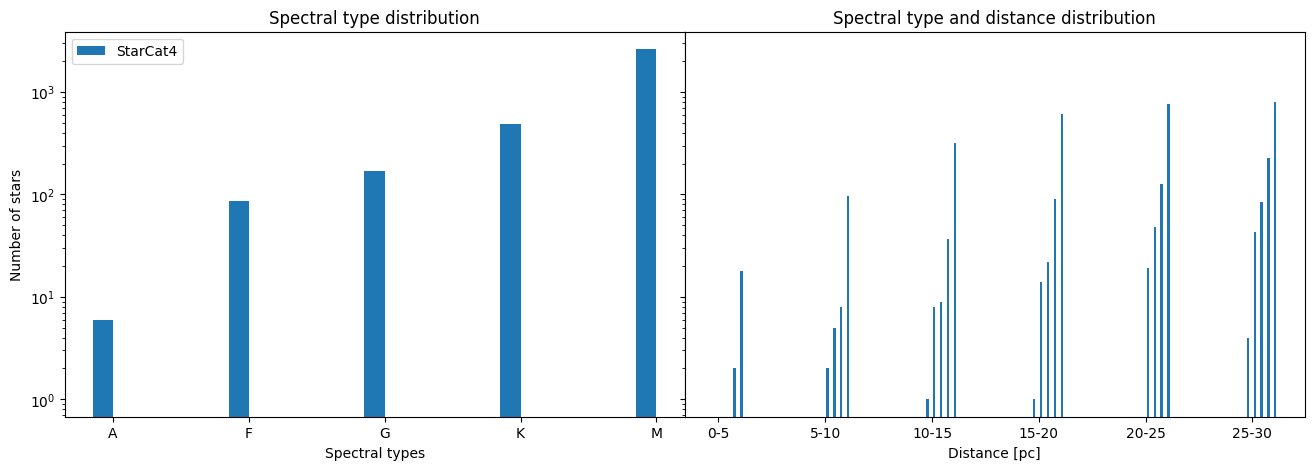

In [25]:
from utils.analysis.finalplot import starcat_distribution_plot

starcat_distribution_plot(
    [StarCat4["class_temp", "dist_st_value"]], ["StarCat4"])

We can observe that the spectral type distribution looks as expected meaning the lower the mass of the star the more of them are within 30pc. We also see that within 20 pc we only have M and K stars in our sample. Also the spectral type distribution of the stars in our catalog between 20-25pc are nearly identical to the ones between 25-30pc. We would expect there to be way more lower mass stars in the further away distance bin. This let's us conclude that at the end of the distance cut our catalog is magnitude limited meaning we miss quite a bit of the faint stars.